# Randomized SVD

Since the full SVD is **slow**. We will inverstigate a *randomized* implementation wich are more stable with performance guarantees.

The ideas discussed in this notebook are taken from the excellent paper [Finding Structur with randomnsess](../documents/finding_structure_with_randomness.pdf)

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
#fetching the dataset
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [4]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [5]:
#Getting the shape of the words 
vocab = np.array(vectorizer.get_feature_names())

In [7]:
vocab.shape

(26576,)

Let's check the time of a fully SVD decomposition

In [6]:
from scipy.linalg import svd
%time U, s, Vh = svd(vectors, full_matrices=False)

CPU times: user 31.9 s, sys: 429 ms, total: 32.3 s
Wall time: 8.29 s


In [7]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


The runtime complexity of SVD is $\mathcal{O}(min(m^2n, mn^2))$. Fortunately; there is a faster way to do it with randomized versions

In [8]:
%time u, s, v = decomposition.randomized_svd(vectors,n_components=5)

CPU times: user 5.97 s, sys: 469 ms, total: 6.44 s
Wall time: 1.7 s


How Randomized SVD works.

**Idea**

1. Compute an orthogonal matrix $Q$ with a small range such as

$$  A \approx QQ^T A $$

2. Compute an SVD decomposition of the smaller matrix 

$$ Q^T A = U \Sigma V$$

## Implementation of the Randomized SVD

Following the instruction in the paper, the method `randmoized_range_finder` finds an orthogonal matrix $Q$ whose range approximates the range of $A$. To do so we will use the $QR$ and $LU$ decomposition. 

> the code is mainly based from the tutorial [scikit-learn.extmath.randomized_svd_source_code](https://github.com/scikit-learn/scikit-learn/blob/14031f65d144e3966113d3daec836e443c6d7a5b/sklearn/utils/extmath.py)

In [10]:
# computes an orthogonal matrix whose range approximates the range of A
# power_iteration_normalizer can be safe_spares_dot
from scipy.linalg import lu, qr
def randomized_range_finder( A, size, n_iter=5):
    
    #Generating an initial random matrix
    Q = np.random.normal(size=(A.shape[1],size))
    
    #repeating n iteration of amelioration
    for i in range(n_iter):
        Q, _ = lu(A @ Q , permute_l=True)
        Q, _ = lu(A.T @ Q, permute_l=True)
    
    Q, _= qr(A @ Q, mode='economic')
    
    return Q

And here is the second step of the paper

In [13]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    
    n_random = n_components + n_oversamples
    
    Q = randomized_range_finder(M, n_random, n_iter)
    
    # project M to the (k + p) dimensional space using the basis vectors
    B = Q.T @ M
    
    # compute the SVD on the thin matrix: (k + p) wide
    Uhat, s, V = svd(B, full_matrices=False)
    del B
    U = Q @ Uhat
    
    return U[:, :n_components], s[:n_components], V[:n_components, :]

Let's time this method

In [14]:
%time u, s, v = randomized_svd(vectors, 5)

CPU times: user 4.46 s, sys: 310 ms, total: 4.77 s
Wall time: 1.26 s


Let's check the error as we vary the number of components

In [15]:
def svd_components_error(n_components):
    #compute the truncated decomposition
    u, s, v = randomized_svd(vectors, n_components)
    
    return np.linalg.norm(vectors - u @ np.diag(s) @ v)

In [16]:
num_components = [3, 5, 10 , 20, 30]

error_num_components = np.array([svd_components_error(n) for  n in num_components])

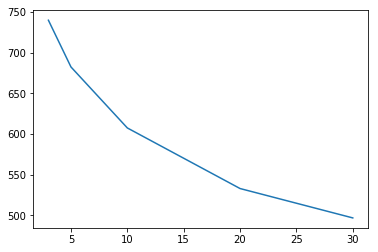

In [17]:
plt.plot(num_components, error_num_components)